## What is attention mechanism?
Each time the model predicts an output word, it only **uses parts of an input where the most relevant information is concentrated** instead of an entire sentence.

## How do we use it?
<img width="647" alt="image" src="https://user-images.githubusercontent.com/35142536/62429376-11405580-b6dc-11e9-8cfa-ae62ac45003b.png">
As you can see in the picture, encoder works as usual, but the decoder’s hidden state is computed with a context vector, the previous output and the previous hidden state. These context vectors are computed as a weighted sum of annotations generated by the encoder.

## Why do we need Attention mechanism?
Seq2Seq model is an “encoder-decoder”. There, one part of the network — encoder — encodes the input sequence into a **fixed-length context vector** and this context vector is then decoded into the output sequence by the decoder. ->  leads to a **decline in performance** when dealing with **long sentences**

> https://medium.com/@joealato/attention-in-nlp-734c6fa9d983

## Practice Code (German -> English)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.reset_default_graph()

In [3]:
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

# combine all the words with " " on the back
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w:i for i, w in enumerate(word_list)}
number_dict = {i:w for i,w in enumerate(word_list)}
n_class = len(word_dict)

print(word_dict)

{'S': 0, 'ich': 1, 'mochte': 2, 'i': 3, 'want': 4, 'a': 5, 'bier': 6, 'E': 7, 'beer': 8, 'P': 9, 'ein': 10}


In [4]:
# parameter
n_step = 5 # maxium number of words in one sentence(=number of time steps)
n_hidden = 128

def make_batch(sentences):
    #one-hot encoding for input and output
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]
    return input_batch, output_batch, target_batch

In [5]:
# model
enc_inputs = tf.placeholder(tf.float32, [None, None, n_class]) # [batch_size, n_step, n_class]
dec_inputs = tf.placeholder(tf.float32, [None, None, n_class])
targets = tf.placeholder(tf.int64, [1, n_step]) # [batch_size, n_step] , one-hot X

# linear for attention
attn = tf.Variable(tf.random_normal([n_hidden, n_hidden]))
out = tf.Variable(tf.random_normal([n_hidden*2, n_class]))

def get_attn_score(dec_output, enc_output):
    score = tf.squeeze(tf.matmul(enc_output, attn), 0)
    dec_output = tf.squeeze(dec_output, [0,1]) 
    return tf.tensordot(dec_output, score, 1)

def get_attn_weight(dec_output, enc_outputs):
    attn_scores = []
    enc_outputs = tf.transpose(enc_outputs, [1,0,2])
    for i in range(n_step):
        attn_scores.append(get_attn_score(dec_output, enc_outputs[i]))

    # Normalize scores to weights in range 0 to 1
    return tf.reshape(tf.nn.softmax(attn_scores), [1, 1, -1])  # [1, 1, n_step]

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model = []
Attention = []

# encode is the same as the original Seq2Seq model
with tf.variable_scope('encode'):
    enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5)
    # enc_outputs : [batch_size(=1), n_step(=decoder_step), n_hidden(=128)]
    # enc_hidden : [batch_size(=1), n_hidden(=128)]
    enc_outputs, enc_hidden = tf.nn.dynamic_rnn(enc_cell, enc_inputs, dtype=tf.float32)


with tf.variable_scope('decode'):
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)

    inputs = tf.transpose(dec_inputs, [1,0,2])
    hidden = enc_hidden
    
    for i in range(n_step):
         # time_major True mean inputs shape: [max_time, batch_size, ...]
        dec_output, hidden = tf.nn.dynamic_rnn(dec_cell, tf.expand_dims(inputs[i], 1),
                                               initial_state=hidden, dtype=tf.float32, time_major=True)
        attn_weights = get_attn_weight(dec_output, enc_outputs) # [1,1,n_step]
        Attention.append(tf.squeeze(attn_weights))
         # matrix-matrix product of matrices [1, 1, n_step] x [1, n_step, n_hidden] = [1, 1, n_hidden]
        context = tf.matmul(attn_weights, enc_outputs)
        dec_output = tf.squeeze(dec_output, 0)  # [1, n_step]
        context = tf.squeeze(context, 1)  # [1, n_hidden]

        model.append(tf.matmul(tf.concat((dec_output, context), 1), out))  # [n_step, batch_size(=1), n_class]
        
trained_attn = tf.stack([Attention[0], Attention[1], Attention[2], Attention[3], Attention[4]],0)
# to show attention matrix
model = tf.transpose(model, [1,0,2]) #model : [n_step, n_class]
prediction = tf.argmax(model,2)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch: 0400 cost = 0.000000
Epoch: 0800 cost = 0.000004
Epoch: 1200 cost = 0.000000
Epoch: 1600 cost = 0.000000
Epoch: 2000 cost = 0.000000
['ich', 'mochte', 'ein', 'bier', 'P'] -> ['i', 'want', 'a', 'beer', 'E']


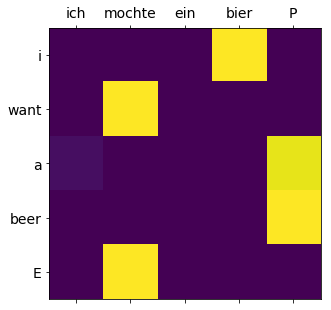

In [7]:
# Training and test
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(2000):
        input_batch, output_batch, target_batch = make_batch(sentences)
        _, loss, attention = sess.run([optimizer, cost, trained_attn], feed_dict={enc_inputs: input_batch, dec_inputs: output_batch, targets: target_batch})
        if (epoch + 1) % 400 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
            
       
    predict_batch = [np.eye(n_class)[[word_dict[n] for n in 'P P P P P'.split()]]]
    result = sess.run(prediction, feed_dict={enc_inputs: input_batch, dec_inputs: predict_batch})
    print(sentences[0].split(), '->', [number_dict[n] for n in result[0]])
        
    # show attention
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()